# Import libraries

In [10]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rc
from GMHI import GMHI

# Set constants

In [11]:
# set figure details
figsize = (10, 10)
dpi = 200

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

filename = "performance_per_study_per_phenotype.svg"

# Load data

In [12]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "is_healthy.csv"), index_col=[0, 1])
phenotype = pd.read_csv(os.path.join(config.CLEAN_DIR, "phenotype.csv"), index_col=[0, 1])
GMHI2_scores_cv = pd.read_csv(os.path.join(config.PREDICTION_DIR, "GMHI2_scores_cv.csv"), index_col=[0, 1])
display(X.head())
display(y.head())
display(GMHI2_scores_cv.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-23  SAMEA3879547        0.019774                     0.019774   
         SAMEA3879551        0.000000                     0.000000   
         SAMEA3879543        0.003253                     0.003253   
         SAMEA3879565        0.008863                     0.008863   
         SAMEA3879546        0.000048                     0.000048   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-23  SAMEA3879547                                            0.019774   
         SAMEA3879551                                            0.000000   
         SAMEA3879543                                            0.003253   
         SAMEA3879565                                            0.008863   
         SAMEA3879546                                            0.000048   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-23  SAMEA3879547                                               0.019774                      
         SAMEA3879551                                               0.000000                      
         SAMEA3879543                                               0.003253                      
         SAMEA3879565                                               0.008863                      
         SAMEA3879546                                               0.000048                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-23  SAMEA3879547                                               0.019774                                             
         SAMEA3879551                                               0.000000                                             
         SAMEA3879543                                               0.003253                                             
         SAMEA3879565                                               0.008863                                             
         SAMEA3879546                                               0.000048                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
GMHI-23  SAMEA3879547                                               0.019774                                                                   
         SAMEA3879551                                               0.000000                                                                   
         SAMEA3879543                                               0.003253                                                                   
         SAMEA3879565                                               0.008863                                                                   
         SAMEA3879546                                               0.000048                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
GMHI-23  SAMEA3879547                                               0.019774              

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-23  SAMEA3879547                              True
         SAMEA3879551                              True
         SAMEA3879543                              True
         SAMEA3879565                              True
         SAMEA3879546                              True

GMHI2_cv
Study_ID Sample Accession          
GMHI-23  SAMEA3879547      1.884788
         SAMEA3879551     -0.062656
         SAMEA3879543     -0.890399
         SAMEA3879565      0.468921
         SAMEA3879546      1.171292

# Rank order and plot

In [14]:
np.unique(phenotype)

array(['Advanced Dementia', 'Ankylosing spondylitis',
       'Atherosclerotic cardiovascular disease', 'Behcet’s disease',
       'Breast Cancer', 'Colorectal adenoma', 'Colorectal cancer',
       "Crohn's Disease", 'End-stage renal disease', 'Graves’ disease',
       'Healthy', 'Hypertension', 'Impaired glucose tolerance',
       'Liver Cirrhosis', 'NAFLD', 'Pancreatic cancer',
       'Rheumatoid arthritis', 'Schizophrenia', 'Type 2 diabetes',
       'Ulcerative colitis'], dtype=object)

In [18]:
info = pd.DataFrame((GMHI2_scores_cv > 0).values, index=GMHI2_scores_cv.index, columns=["predicted"])
info["phenotype"] = phenotype
info["y"] = y

# remove samples with low GMHI2 score magnitudes
cutoff = 0.1
info = info[(abs(GMHI2_scores_cv) > cutoff).values]
info

predicted           phenotype      y
Study_ID Sample Accession                                      
GMHI-23  SAMEA3879547           True             Healthy   True
         SAMEA3879543          False             Healthy   True
         SAMEA3879565           True             Healthy   True
         SAMEA3879546           True             Healthy   True
         SAMEA3879522           True             Healthy   True
...                              ...                 ...    ...
P140     SAMN07509562          False  Ulcerative colitis  False
         SAMN07509555          False  Ulcerative colitis  False
         SAMN07509557           True  Ulcerative colitis  False
         SAMN07509546          False  Ulcerative colitis  False
         SAMN07509552          False  Ulcerative colitis  False

[8580 rows x 3 columns]

In [31]:
study_scores = []

for p in np.unique(phenotype):
    phenotype_df = info[(info["phenotype"] == p).values]
    phenotype_studies = np.unique(phenotype_df.index.get_level_values(0))
    for s in phenotype_studies:
        curr_df = phenotype_df.loc[s]
        acc = accuracy_score(curr_df["y"], curr_df["predicted"])
        study_scores.append({
            "phenotype" : p,
            "study" : s,
            "acc" : acc
        })

In [44]:
df = pd.DataFrame(sorted(study_scores, key=lambda x : (x["phenotype"], 1 - x["acc"]), ))
df = df.set_index(["phenotype", "study"])
df

acc
phenotype                              study              
Advanced Dementia                      P113       0.986842
Ankylosing spondylitis                 GMHI-V-41  0.704545
Atherosclerotic cardiovascular disease GMHI-2     0.966825
Behcet’s disease                       P15        0.750000
Breast Cancer                          P32        0.850000
...                                                    ...
Ulcerative colitis                     P57        0.714286
                                       P56        0.635135
                                       GMHI-28    0.633333
                                       P140       0.521739
                                       GMHI-9     0.343750

[96 rows x 1 columns]

In [88]:
phenotypes = np.unique(phenotype)
phenotypes, phenotypes.shape[0]

(array(['Advanced Dementia', 'Ankylosing spondylitis',
        'Atherosclerotic cardiovascular disease', 'Behcet’s disease',
        'Breast Cancer', 'Colorectal adenoma', 'Colorectal cancer',
        "Crohn's Disease", 'End-stage renal disease', 'Graves’ disease',
        'Healthy', 'Hypertension', 'Impaired glucose tolerance',
        'Liver Cirrhosis', 'NAFLD', 'Pancreatic cancer',
        'Rheumatoid arthritis', 'Schizophrenia', 'Type 2 diabetes',
        'Ulcerative colitis'], dtype=object),
 20)

In [81]:
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, phenotypes.shape[0]))
color_dic = dict([(p, colors[i]) for i, p in enumerate(phenotypes)])
color_dic

{'Advanced Dementia': array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 'Ankylosing spondylitis': array([0.68235294, 0.78039216, 0.90980392, 1.        ]),
 'Atherosclerotic cardiovascular disease': array([1.        , 0.49803922, 0.05490196, 1.        ]),
 'Behcet’s disease': array([1.        , 0.73333333, 0.47058824, 1.        ]),
 'Breast Cancer': array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 'Colorectal adenoma': array([0.59607843, 0.8745098 , 0.54117647, 1.        ]),
 'Colorectal cancer': array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
 "Crohn's Disease": array([1.        , 0.59607843, 0.58823529, 1.        ]),
 'End-stage renal disease': array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 'Graves’ disease': array([0.77254902, 0.69019608, 0.83529412, 1.        ]),
 'Healthy': array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 'Hypertension': array([0.76862745, 0.61176471, 0.58039216, 1.        ]),
 'Impaired glucose tolerance': array([0.890

In [82]:
colors = [color_dic[p] for p in df.index.get_level_values(0)]
colors[:10]

[array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([0.68235294, 0.78039216, 0.90980392, 1.        ]),
 array([1.        , 0.49803922, 0.05490196, 1.        ]),
 array([1.        , 0.73333333, 0.47058824, 1.        ]),
 array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 array([0.59607843, 0.8745098 , 0.54117647, 1.        ]),
 array([0.59607843, 0.8745098 , 0.54117647, 1.        ]),
 array([0.59607843, 0.8745098 , 0.54117647, 1.        ]),
 array([0.59607843, 0.8745098 , 0.54117647, 1.        ]),
 array([0.83921569, 0.15294118, 0.15686275, 1.        ])]

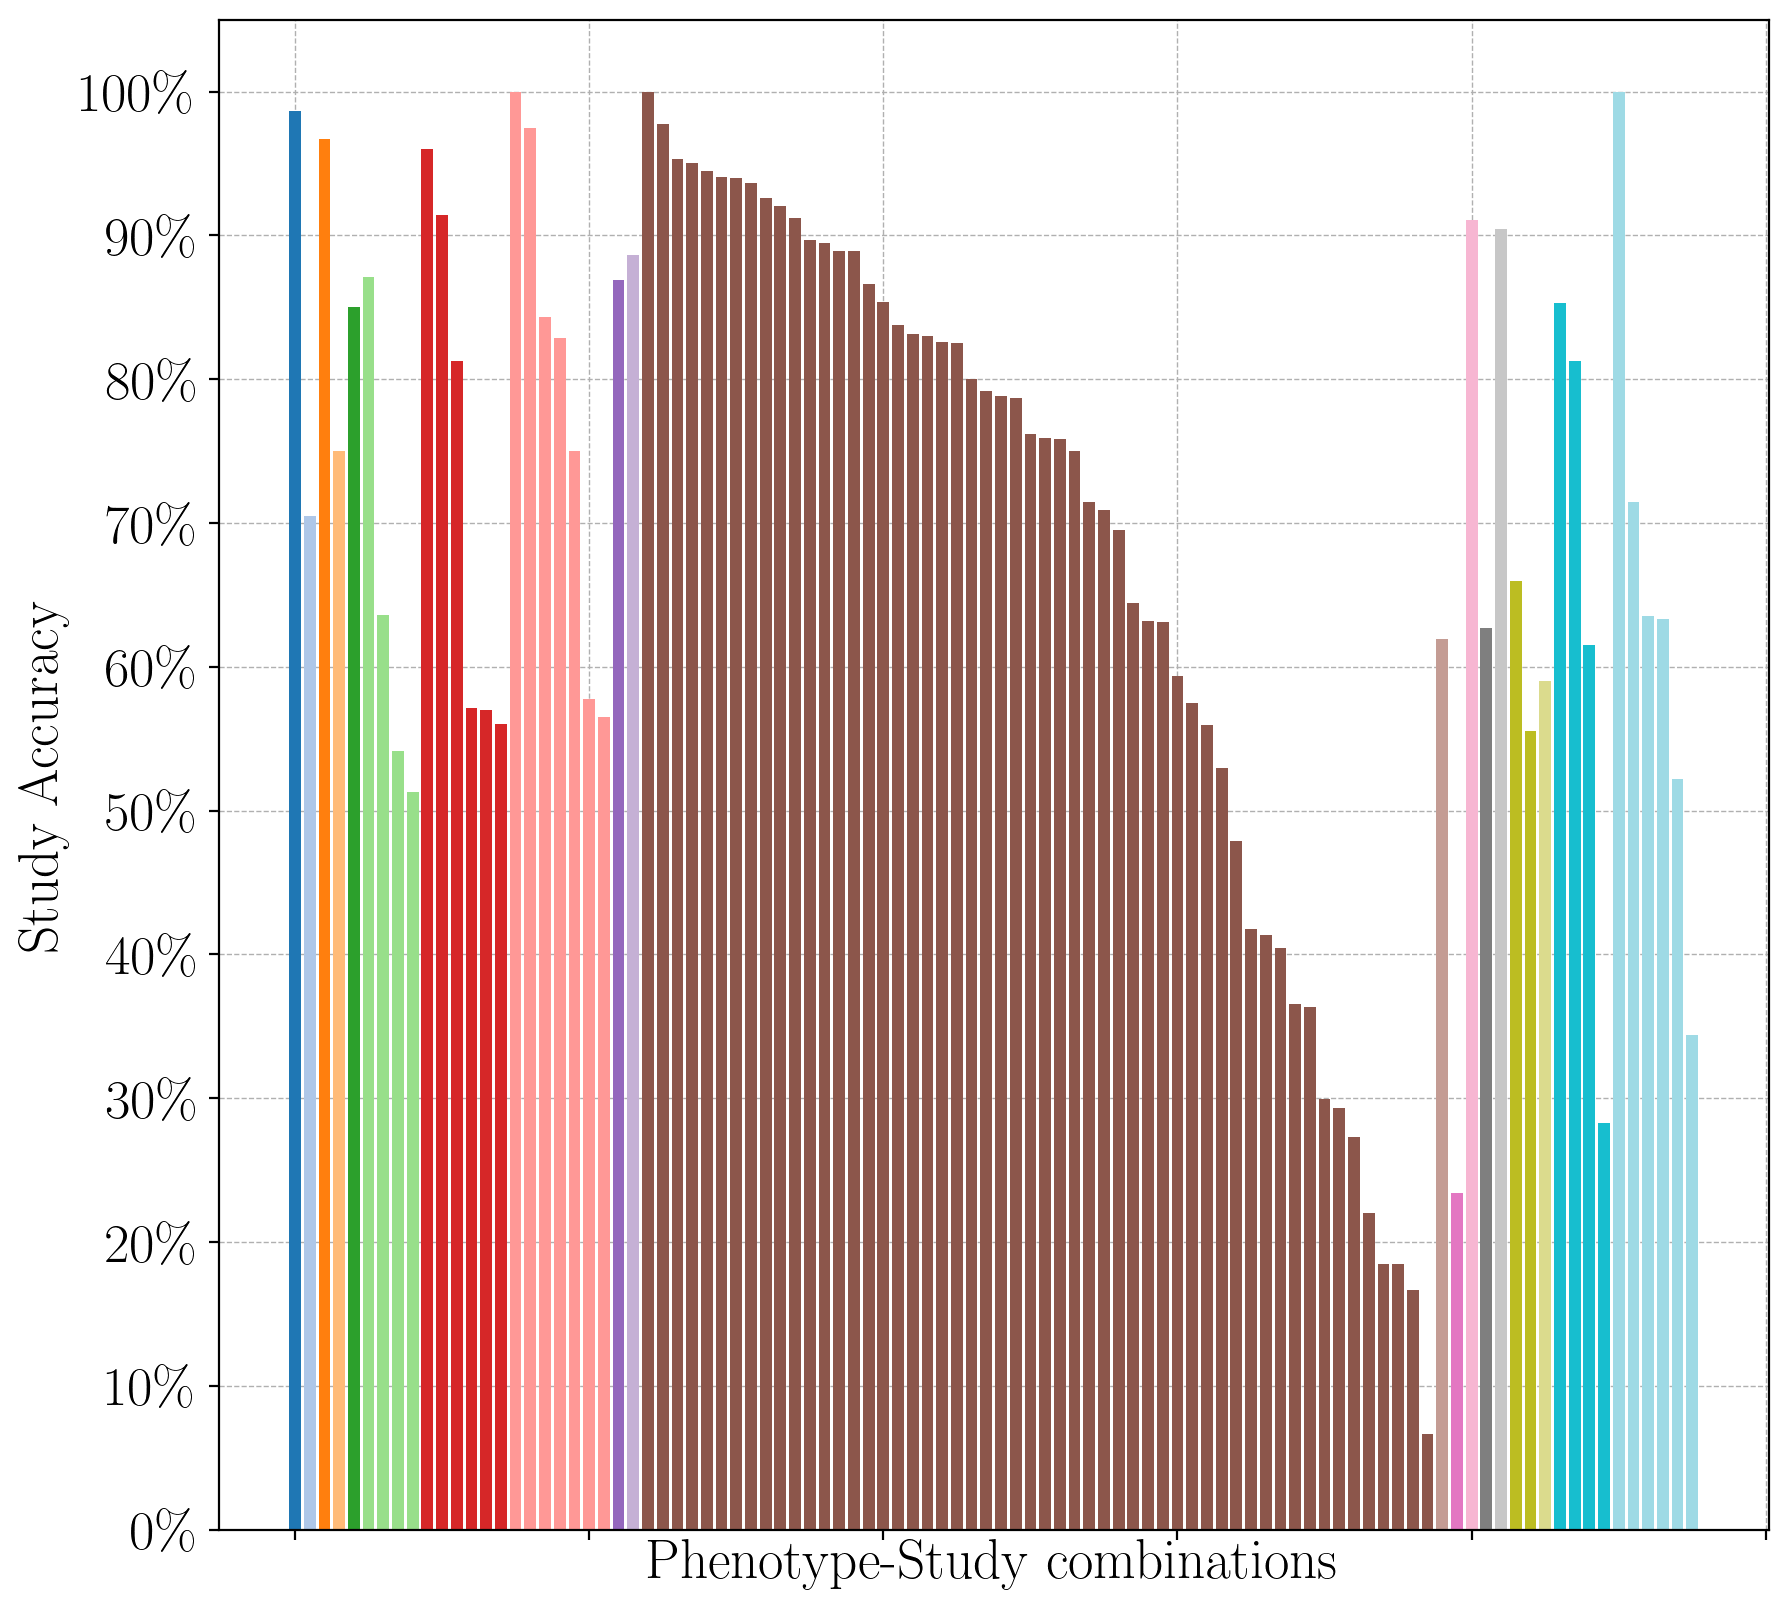

In [95]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.tick_params(axis="both", labelsize=20)
plt.yticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Phenotype-Study combinations", fontsize=20)
ax.tick_params(labelbottom=False)

ax.set_axisbelow(True)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.grid(linestyle = '--', linewidth = 0.5)

ax.set_ylabel("Study Accuracy", fontsize=20)
plt.bar(np.arange(0, df.shape[0]), df["acc"].values, color=colors)
plt.savefig(os.path.join(config.FIGURE_DIR, filename))